In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bin import utils

In [8]:
scdata = sc.read_h5ad('./RNA/sc.combined.dedup.clustered.h5')
scdata = scdata[~scdata.obs['leiden'].isna()].copy()

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


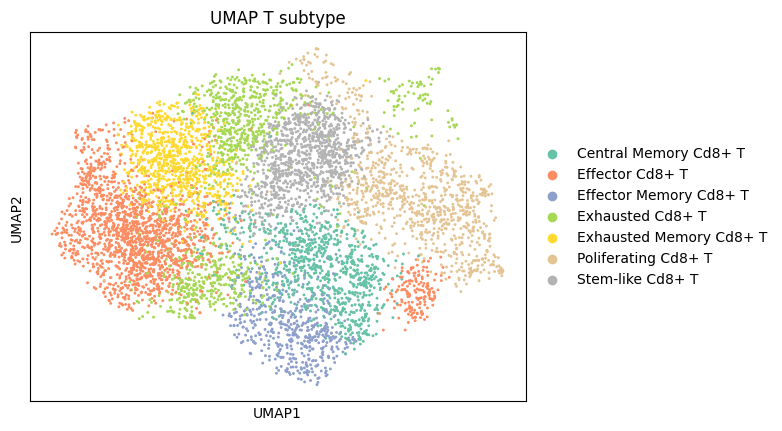

In [21]:
ax = sc.pl.umap(scdata, color=['leiden'], palette='Set2', return_fig=True).gca()
ax.set_title('UMAP T subtype')
plt.show()

In [22]:
sc.tl.embedding_density(scdata, basis='umap', groupby='perturb_gene')

# Chemokine Receptor <-> Phenotype

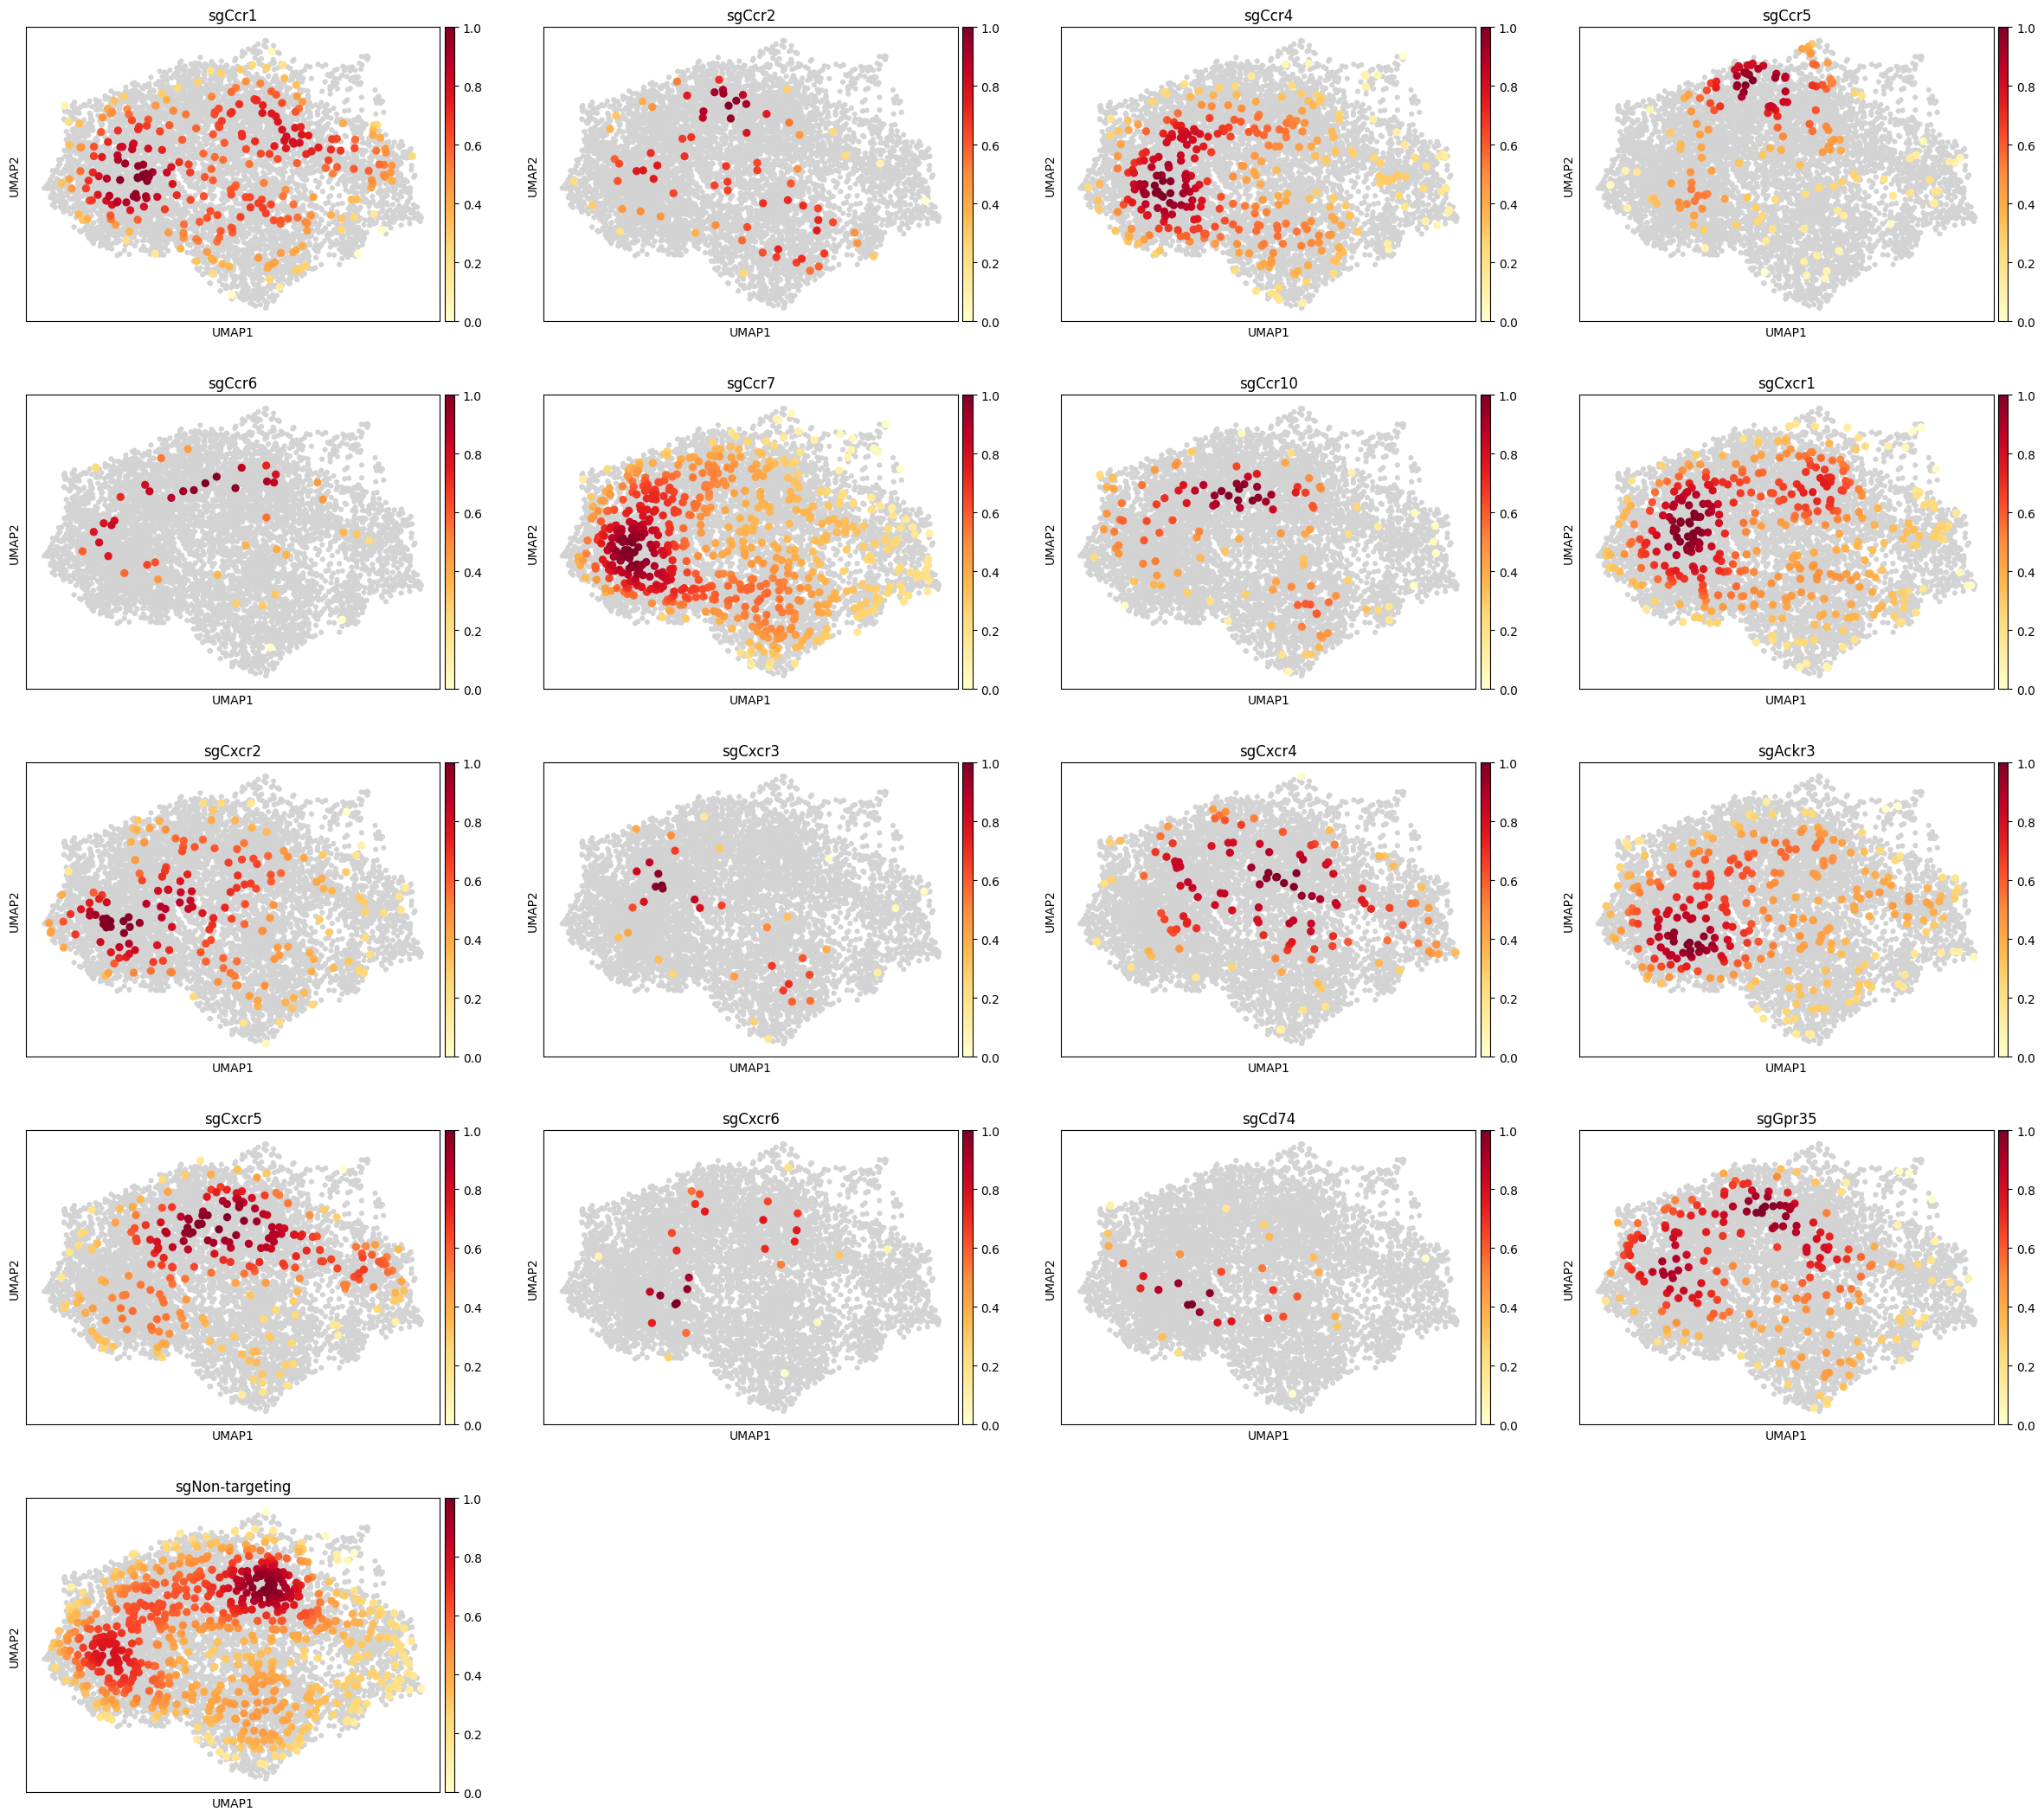

In [29]:
chemokine_list = ["sgCcr1", "sgCcr2", "sgCcr4", "sgCcr5", "sgCcr6",
    "sgCcr7", "sgCcr10", "sgCxcr1", "sgCxcr2", "sgCxcr3", "sgCxcr4",
    "sgAckr3", "sgCxcr5", "sgCxcr6", "sgCd74", "sgGpr35", 'sgNon-targeting']
sc.pl.embedding_density(scdata, basis='umap', key='umap_density_perturb_gene', group=chemokine_list)

/tmp/ipykernel_59679/1985088795.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cdf = chem_data.obs.groupby('perturb_gene')['leiden'].value_counts().unstack()


Text(0.5, 1.0, 'Proportion of T subtype')

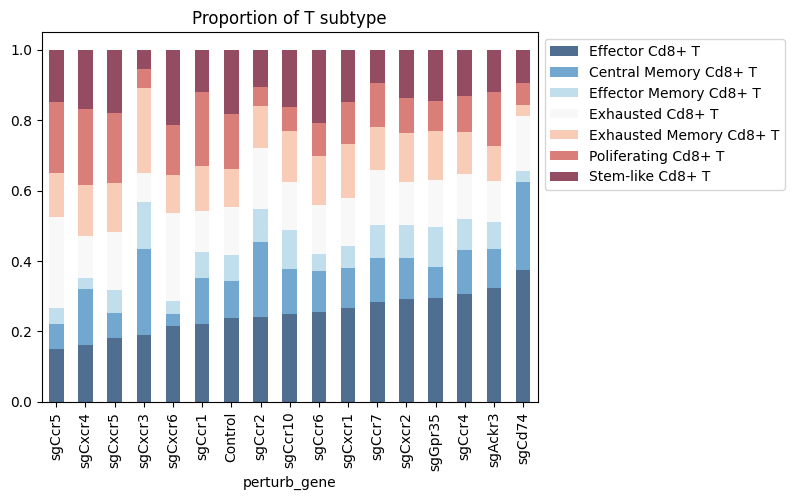

In [102]:
chem_data = scdata[np.isin(scdata.obs.perturb_gene, chemokine_list)].copy()
cdf = chem_data.obs.groupby('perturb_gene')['leiden'].value_counts().unstack()
cdf = cdf.divide(cdf.sum(axis=1), axis=0)
cdf = cdf[['Effector Cd8+ T'] + list(cdf.columns[cdf.columns != 'Effector Cd8+ T'])]
cdf.index = cdf.index.str.replace('sgNon-targeting', 'Control')
cdf.sort_values(by='Effector Cd8+ T', inplace=True)

cdf.plot(kind='bar', stacked=True, colormap='RdBu_r', alpha=0.7)
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Proportion of T subtype')

In [109]:
import plotly.graph_objects as go

# 示例数据
data = chem_data.obs[["perturb_gene", "leiden"]]
data.columns = ["perturb_gene", "cluster"]

df = pd.DataFrame(data)

# 计算流量值（在这里，每个组合的频率）
flows = df.groupby(['perturb_gene', 'cluster']).size().reset_index(name='count')

# 创建源、目标和值的列表
source_indices = []
target_indices = []
values = []

# 获取唯一的perturb_gene和cluster
unique_genes = flows['perturb_gene'].unique()
unique_clusters = flows['cluster'].unique()

# 创建索引映射
gene_indices = {gene: idx for idx, gene in enumerate(unique_genes)}
cluster_indices = {cluster: idx + len(unique_genes) for idx, cluster in enumerate(unique_clusters)}

# 构建源、目标和值列表
for index, row in flows.iterrows():
    source_indices.append(gene_indices[row['perturb_gene']])
    target_indices.append(cluster_indices[row['cluster']])
    values.append(row['count'])

# 计算每个perturb_gene的流量总和
total_flows_per_gene = flows.groupby('perturb_gene')['count'].sum()

# 计算每个perturb_gene的流量占比
flows['total_gene_flow'] = flows['perturb_gene'].map(total_flows_per_gene)
flows.total_gene_flow = flows.total_gene_flow.astype(int)
flows['color_intensity'] = flows['count'] / flows['total_gene_flow']

# 创建颜色映射
import matplotlib.cm as cm
colors = [cm.RdBu_r(2.5*x) for x in flows['color_intensity']]
    
# 创建Sankey图
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(unique_genes) + list(unique_clusters),
        color="Orange"
    ),
    link=dict(
        source=source_indices,
        target=target_indices,
        value=values,
        color=[f"rgba({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)}, 0.7)" for color in colors],
    )
)])

# 更新布局
fig.update_layout(title_text="Sankey Diagram of perturb_gene to cluster", font_size=10)
fig.update_layout(
    width=600,  # 设置宽度
    height=1200,  # 设置高度
)
fig.show()

/tmp/ipykernel_59679/636262902.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  flows = df.groupby(['perturb_gene', 'cluster']).size().reset_index(name='count')
/tmp/ipykernel_59679/636262902.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_flows_per_gene = flows.groupby('perturb_gene')['count'].sum()


# TF <-> Chemokine Receptor

In [194]:
chemokine_list = ["sgCcr1", "sgCcr2", "sgCcr4", "sgCcr5", "sgCcr6",
    "sgCcr7", "sgCcr10", "sgCxcr1", "sgCxcr2", "sgCxcr3", "sgCxcr4",
    "sgAckr3", "sgCxcr5", "sgCxcr6", "sgCd74", "sgGpr35"]
tf_data = scdata[~np.isin(scdata.obs.perturb_gene, chemokine_list)].copy()

In [138]:
gsea_chemokine_rc = ["Ackr2", "Ackr3", "Ackr4",
    "Ccl1", "Ccl11", "Ccl12", "Ccl17", "Ccl19",
    "Ccl20", "Ccl21a", "Ccl21b", "Ccl21d", "Ccl21e",
    "Ccl21f", "Ccl22", "Ccl25", "Ccl27a", "Ccl27al",
    "Ccl27b", "Ccl28", "Ccl3", "Ccl4", "Ccl5", "Ccr10",
    "Ccr3", "Ccr4", "Ccr5", "Ccr6", "Ccr7", "Ccr8",
    "Ccr9", "Ccrl2", "Cx3cl1", "Cx3cr1", "Cxcl1",
    "Cxcl10", "Cxcl11", "Cxcl12", "Cxcl13", "Cxcl16",
    "Cxcl2", "Cxcl3", "Cxcl5", "Cxcl9", "Cxcr1",
    "Cxcr2", "Cxcr3", "Cxcr4", "Cxcr5", "Cxcr6",
    "Pf4", "Ppbp", "Xcl1", "Xcr1"]

In [196]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Text(0, 0.5, 'Perturbation')

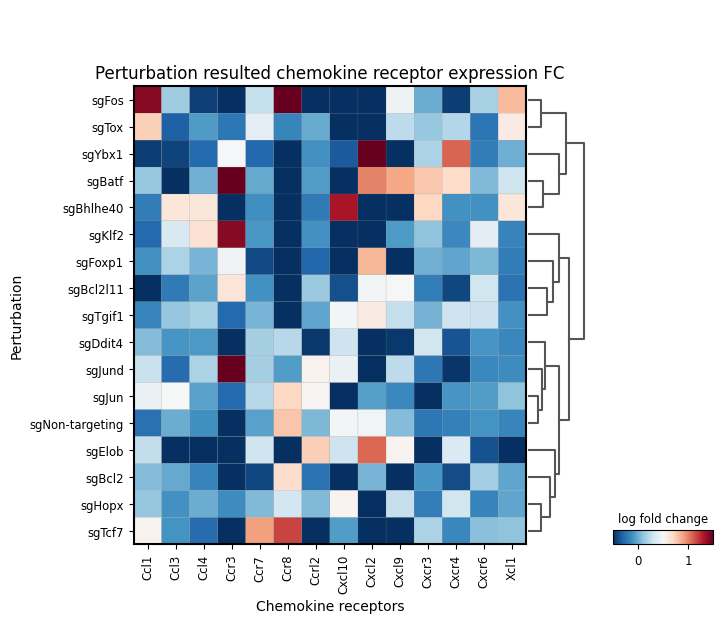

In [197]:
sc.tl.rank_genes_groups(tf_data, groupby='perturb_gene', method='t-test')
ax = sc.pl.rank_genes_groups_matrixplot(tf_data, cmap='RdBu_r',
    values_to_plot='logfoldchanges', var_names=np.array(gsea_chemokine_rc)[np.isin(gsea_chemokine_rc, scdata.var_names)],
    vmin=-0.5, vmax=1.5, return_fig=True)
ax.get_axes()['mainplot_ax'].set_title('Perturbation resulted chemokine receptor expression FC')
ax.get_axes()['mainplot_ax'].set_xlabel('Chemokine receptors')
ax.get_axes()['mainplot_ax'].set_ylabel('Perturbation')

# TF <-> Phenotype

In [110]:
chemokine_list = ["sgCcr1", "sgCcr2", "sgCcr4", "sgCcr5", "sgCcr6",
    "sgCcr7", "sgCcr10", "sgCxcr1", "sgCxcr2", "sgCxcr3", "sgCxcr4",
    "sgAckr3", "sgCxcr5", "sgCxcr6", "sgCd74", "sgGpr35"]
tf_data = scdata[~np.isin(scdata.obs.perturb_gene, chemokine_list)].copy()

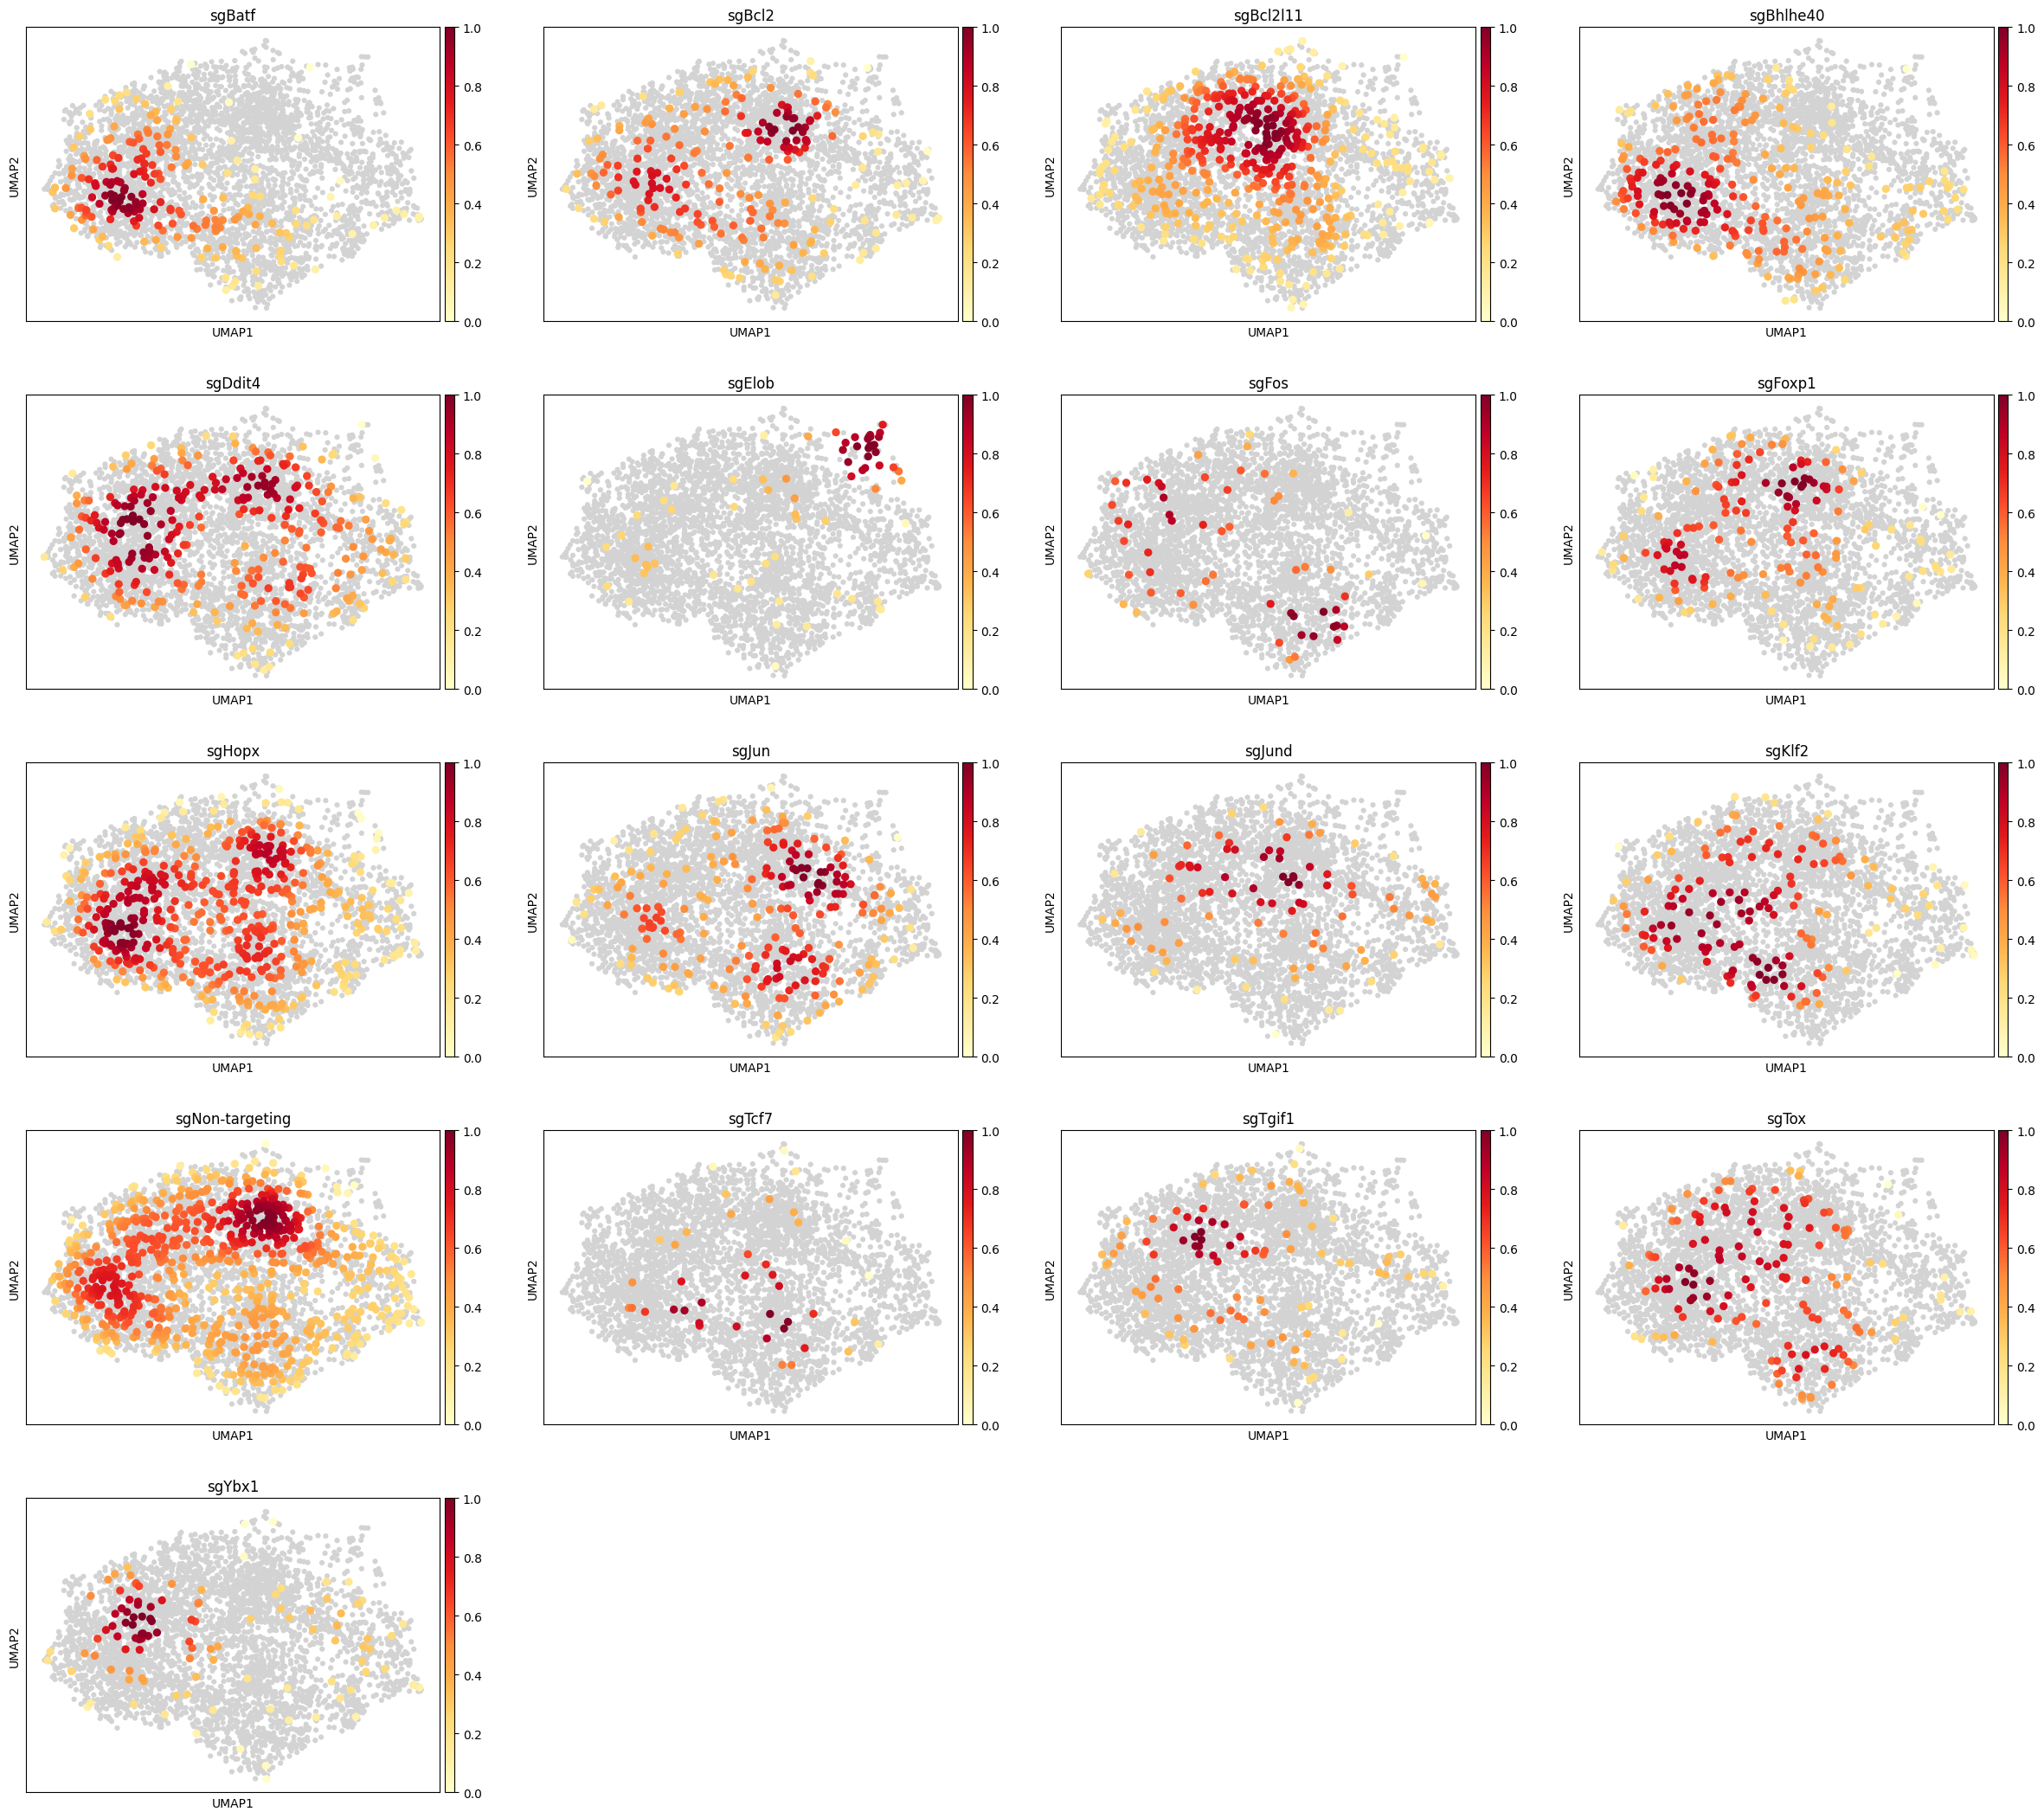

In [113]:
sc.pl.embedding_density(tf_data, basis='umap', key='umap_density_perturb_gene')

/tmp/ipykernel_59679/3342638479.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Text(0.5, 1.0, 'Proportion of T subtype')

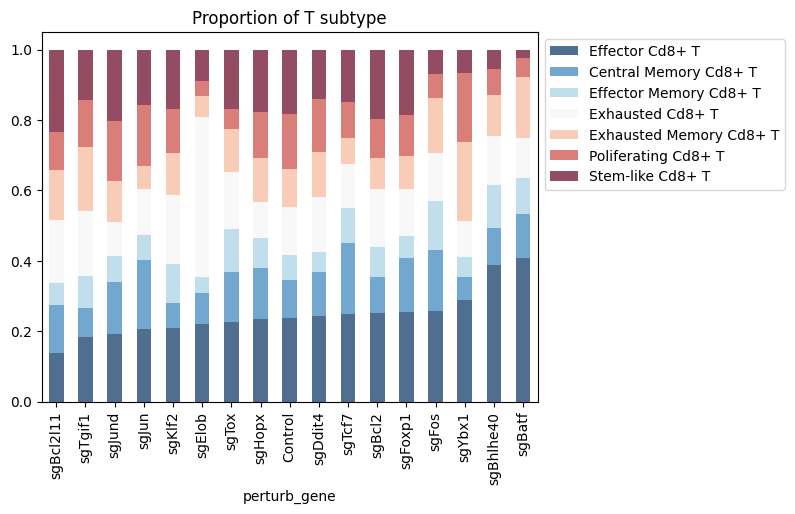

In [115]:
cdf = tf_data.obs.groupby('perturb_gene')['leiden'].value_counts().unstack()
cdf = cdf.divide(cdf.sum(axis=1), axis=0)
cdf = cdf[['Effector Cd8+ T'] + list(cdf.columns[cdf.columns != 'Effector Cd8+ T'])]
cdf.index = cdf.index.str.replace('sgNon-targeting', 'Control')
cdf.sort_values(by='Effector Cd8+ T', inplace=True)

cdf.plot(kind='bar', stacked=True, colormap='RdBu_r', alpha=0.7)
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Proportion of T subtype')

In [116]:
import plotly.graph_objects as go

# 示例数据
data = tf_data.obs[["perturb_gene", "leiden"]]
data.columns = ["perturb_gene", "cluster"]

df = pd.DataFrame(data)

# 计算流量值（在这里，每个组合的频率）
flows = df.groupby(['perturb_gene', 'cluster']).size().reset_index(name='count')

# 创建源、目标和值的列表
source_indices = []
target_indices = []
values = []

# 获取唯一的perturb_gene和cluster
unique_genes = flows['perturb_gene'].unique()
unique_clusters = flows['cluster'].unique()

# 创建索引映射
gene_indices = {gene: idx for idx, gene in enumerate(unique_genes)}
cluster_indices = {cluster: idx + len(unique_genes) for idx, cluster in enumerate(unique_clusters)}

# 构建源、目标和值列表
for index, row in flows.iterrows():
    source_indices.append(gene_indices[row['perturb_gene']])
    target_indices.append(cluster_indices[row['cluster']])
    values.append(row['count'])

# 计算每个perturb_gene的流量总和
total_flows_per_gene = flows.groupby('perturb_gene')['count'].sum()

# 计算每个perturb_gene的流量占比
flows['total_gene_flow'] = flows['perturb_gene'].map(total_flows_per_gene)
flows.total_gene_flow = flows.total_gene_flow.astype(int)
flows['color_intensity'] = flows['count'] / flows['total_gene_flow']

# 创建颜色映射
import matplotlib.cm as cm
colors = [cm.RdBu_r(2.5*x) for x in flows['color_intensity']]
    
# 创建Sankey图
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(unique_genes) + list(unique_clusters),
        color="Orange"
    ),
    link=dict(
        source=source_indices,
        target=target_indices,
        value=values,
        color=[f"rgba({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)}, 0.7)" for color in colors],
    )
)])

# 更新布局
fig.update_layout(title_text="Sankey Diagram of perturb_gene to cluster", font_size=10)
fig.update_layout(
    width=600,  # 设置宽度
    height=1200,  # 设置高度
)
fig.show()

/tmp/ipykernel_59679/1350086214.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_59679/1350086214.py:32: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

